In [1]:
import os
os.environ['PATH'] += ':ffmpeg-3.4.2-64bit-static'

# Setup

In [2]:
exp_directory = 'results'
agent_name = 'DeepQAgent'
game_name = 'Breakout'
render_mode='rgb_array'

### Global Modules

In [3]:
import os
import datetime
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline
from gym.wrappers import Monitor

### Local Modules

In [4]:
import base
from src.agents import DeepQAgent, A3CAgent
from src.util import BaseCallback, JupyterCallback
from src.environment.atari import build_atari_environment

/usr/local/anaconda5/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
/usr/local/anaconda5/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


## Constants

In [5]:
agents = {
    DeepQAgent.__name__: DeepQAgent,
    A3CAgent.__name__: A3CAgent,
}

#### Output Directory

In [6]:
# setup the experiment directory
now = datetime.datetime.today().strftime('%Y-%m-%d_%H-%M')
exp_directory = '{}/{}/{}/{}'.format(exp_directory, game_name, agent_name, now)
if not os.path.exists(exp_directory):
    os.makedirs(exp_directory)
exp_directory

'results/Breakout/DeepQAgent/2018-04-16_01-56'

In [7]:
plot_dir = '{}/plots'.format(exp_directory)
if not os.path.exists(plot_dir):
    os.makedirs(plot_dir)
plot_dir

'results/Breakout/DeepQAgent/2018-04-16_01-56/plots'

# Environment

In [8]:
env = build_atari_environment(game_name)
env = Monitor(env, '{}/monitor'.format(exp_directory), force=True)

In [9]:
env.observation_space

Box(84, 84, 4)

In [10]:
env.action_space

Discrete(4)

# Agent

In [11]:
agent = agents[agent_name](env, render_mode=render_mode)
agent

DeepQAgent(
    env=<Monitor<FrameStackEnv<ClipRewardEnv<PenalizeDeathEnv<DownsampleEnv<FireResetEnv<MaxFrameskipEnv<NoopResetEnv<TimeLimit<AtariEnv<BreakoutNoFrameskip-v4>>>>>>>>>>>,
    render_mode='rgb_array'
    replay_memory_size=1000000,
    discount_factor=0.99,
    update_frequency=4,
    optimizer=<keras.optimizers.Adam object at 0x2ab10e0480f0>,
    exploration_rate=AnnealingVariable(initial_value=1.0, final_value=0.1, steps=1000000),
    loss=huber_loss,
    target_update_freq=10000,
    dueling_network=True
)

In [12]:
# write some info about the agent to disk
with open('{}/agent.py'.format(exp_directory), 'w') as agent_file:
    agent_file.write(repr(agent))

## Initial

In [13]:
initial = agent.play()
initial = pd.Series(initial)
initial

100%|██████████| 100/100 [02:22<00:00,  1.43s/game]


0    -5.0
1     1.0
2    -5.0
3     1.0
4     1.0
5     1.0
6    -5.0
7    -5.0
8    -5.0
9    -5.0
10    1.0
11   -5.0
12   -5.0
13   -5.0
14   -5.0
15   -5.0
16   -5.0
17    1.0
18   -5.0
19   -5.0
20   -5.0
21    0.0
22    1.0
23   -5.0
24   -5.0
25   -5.0
26   -5.0
27   -5.0
28   -5.0
29   -5.0
     ... 
70   -5.0
71   -5.0
72   -5.0
73   -5.0
74   -5.0
75   -5.0
76   -5.0
77    1.0
78    1.0
79   -5.0
80   -5.0
81   -5.0
82   -5.0
83   -5.0
84   -5.0
85   -5.0
86    1.0
87   -5.0
88    1.0
89    1.0
90    1.0
91   -5.0
92    1.0
93   -5.0
94   -5.0
95   -5.0
96   -5.0
97   -5.0
98   -5.0
99    1.0
Length: 100, dtype: float64

In [14]:
initial.to_csv('{}/initial.csv'.format(exp_directory))

In [15]:
initial.describe()

count    100.000000
mean      -3.450000
std        2.629956
min       -5.000000
25%       -5.000000
50%       -5.000000
75%        0.250000
max        1.000000
dtype: float64

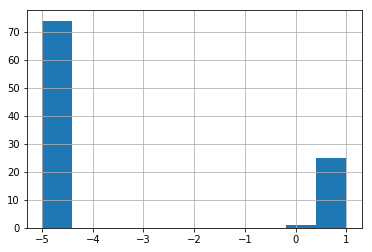

In [16]:
initial.hist()
plt.savefig('{}/initial.pdf'.format(plot_dir))

## Training

In [17]:
agent.observe()

50087frame [01:01, 817.62frame/s]                        


In [18]:
callback = BaseCallback()

In [19]:
agent.train(callback=callback)

 97%|█████████▋| 9703523/10000000 [17:14:25<31:22, 157.46frame/s, loss=3.08, score=73]   

KeyboardInterrupt: 

In [20]:
# save the training results
scores = pd.Series(callback.scores)
scores.to_csv('{}/scores.csv'.format(exp_directory))
losses = pd.Series(callback.losses)
losses.to_csv('{}/losses.csv'.format(exp_directory))

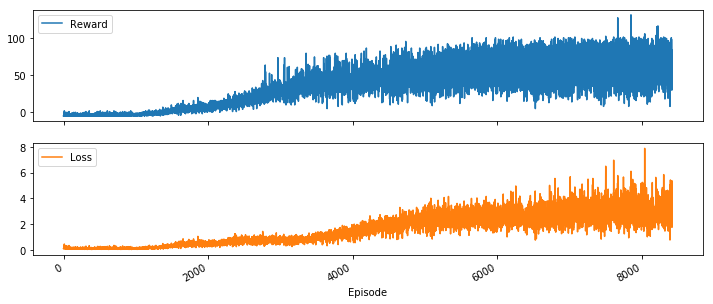

In [21]:
train = pd.concat([scores, losses], axis=1)
train.columns = ['Reward', 'Loss']
train.index.name = 'Episode'
_ = train.plot(figsize=(12, 5), subplots=True)
plt.savefig('{}/training.pdf'.format(plot_dir))

## Final

In [24]:
final = agent.play()
final = pd.Series(final)
final


100%|██████████| 100/100 [10:50<00:00,  6.50s/game]


0      98.0
1      91.0
2      89.0
3     101.0
4      50.0
5      99.0
6      98.0
7     102.0
8      76.0
9      89.0
10     76.0
11     83.0
12     95.0
13     80.0
14     30.0
15     93.0
16     86.0
17     99.0
18     44.0
19     64.0
20    110.0
21     88.0
22     98.0
23     94.0
24     82.0
25     99.0
26     96.0
27     95.0
28    101.0
29     45.0
      ...  
70     93.0
71     95.0
72     66.0
73    100.0
74     98.0
75    100.0
76     88.0
77     83.0
78     97.0
79    102.0
80     93.0
81    102.0
82     39.0
83    100.0
84     90.0
85     85.0
86     96.0
87     95.0
88     63.0
89     89.0
90    117.0
91     79.0
92    100.0
93     89.0
94     60.0
95     93.0
96     98.0
97     94.0
98     95.0
99     76.0
Length: 100, dtype: float64

In [25]:
final.to_csv('{}/final.csv'.format(exp_directory))

In [26]:
final.describe()

count    100.000000
mean      85.560000
std       18.147722
min       27.000000
25%       81.750000
50%       91.000000
75%       98.000000
max      117.000000
dtype: float64

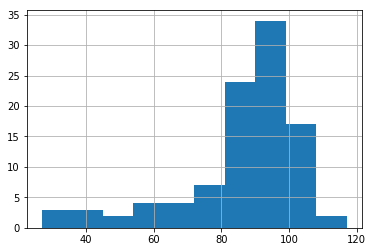

In [27]:
final.hist()
plt.savefig('{}/final.pdf'.format(plot_dir))

## Saving Weights

In [28]:
agent.model.save_weights('{}/weights.h5'.format(exp_directory), overwrite=True)